# Homework 2 - Excel with Python

## Preliminaries

In [1]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

Import commonly used libraries and magic command for inline plotting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
from whatif import Model
from whatif import get_sim_results_df

## Analysis 1 - Basic Break Even Analysis

### Base Model

First, I want to setup the Base Model by defining base input variables and creating functions for basic calculations.

In [5]:
class SingleProductSPF(Model):
    """Base model"""
    def __init__(self, fixed_cost=0, var_cost=0, selling_price=0, spf_constant=0, spf_linear=0, spf_quadratic=0):
        self.fixed_cost = fixed_cost
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.spf_constant = spf_constant
        self.spf_linear = spf_linear
        self.spf_quadratic = spf_quadratic
        
    def update(self, param_dict):
        """Update parameter values"""
        for key in param_dict:
            setattr(self, key, param_dict[key])
    
    def order_demand(self):
        """Compute demand"""
        order_demand = self.spf_quadratic * self.selling_price**2 - self.spf_linear * self.selling_price + self.spf_constant
        return order_demand
    
    def sales_revenue(self):
        """Compute sales revenue"""
        return self.order_demand() * self.selling_price
    
    def order_cost(self):
        """Compute order cost"""
        return self.var_cost * self.order_demand() + self.fixed_cost
    
    def profit(self):
         """Compute profit"""
         profit = self.sales_revenue() - self.order_cost()
         return profit
    
    def __str__(self):
        """String representation of model inputs"""
        return str(vars(self))

In [6]:
# Base Inputs
base_inputs = {'fixed_cost': 5000,
            'var_cost': 100,
            'selling_price': 115,
            'spf_constant': 4900,
            'spf_linear': 35,
            'spf_quadratic': 0.06}

model_1 = SingleProductSPF()
model_1.update(base_inputs)
print(model_1)
#model_1 = SingleProductSPF(fixed_cost, var_cost, selling_price, spf_constant, spf_linear, spf_quadratic)

{'fixed_cost': 5000, 'var_cost': 100, 'selling_price': 115, 'spf_constant': 4900, 'spf_linear': 35, 'spf_quadratic': 0.06}


In [7]:
print(model_1.order_demand())

1668.5


In [8]:
print(model_1.sales_revenue())

191877.5


In [9]:
print(model_1.profit())

20027.5


### 1-way Data Table

In [10]:
from itertools import product
from sklearn.model_selection._search import ParameterGrid
import copy

In [11]:
# create input parameter for price
dt_param_ranges_1 = {'selling_price': np.arange(80, 141, 10)}

# Specify desired outputs (list)
outputs = ['profit', 'order_demand']

# Use data_table function to create 1-way data table
m1_dt1_df = model_1.data_table(dt_param_ranges_1, outputs)
m1_dt1_df

,selling_price,profit,order_demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


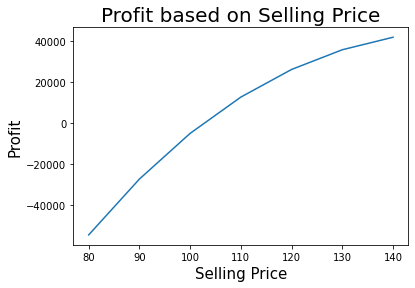

In [12]:
sns.lineplot(data = m1_dt1_df, x = "selling_price", y = "profit");

plt.title('Profit based on Selling Price', fontsize = 20)
plt.xlabel('Selling Price', fontsize = 15)
plt.ylabel('Profit', fontsize = 15);

 - Profit and Selling price appear to have a linear relationship. As Selling price increases so does the Profit. You can see right around selling price of 120 dollars the increase in profit starts to decrease compared to the previous 10 dollar increase. It's also important to note that we cross-over the break-even point somewhere between selling price of 100 and 110.
 - Just for fun I wanted to see what a 3D plot would look like if I added in demand. Let's take a look. 

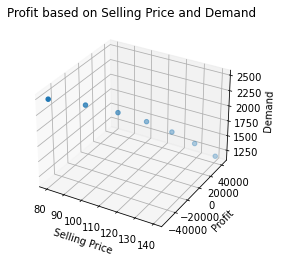

In [13]:
# Create a 3D plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(m1_dt1_df['selling_price'], m1_dt1_df['profit'], m1_dt1_df['order_demand'], 
                cmap=plt.cm.viridis)

ax.set_title('Profit based on Selling Price and Demand')
ax.set_xlabel('Selling Price')
ax.set_ylabel('Profit')
ax.set_zlabel('Demand')

plt.show();

 - From this view you can see that we still make the most profit from selling price of 140 dollars but we also are only meeting a demand of 1250. 

### Break Even

In [14]:
model_1.goal_seek('profit', 0, 'selling_price', 80, 140, N=100)

102.57578606424767

 - The break-even on selling price would be approximately 102 dollars.

In [15]:
break_even_demand = model_1.goal_seek('profit', 0, 'selling_price', 80, 140)

In [16]:
m1_dt1_df

,selling_price,profit,order_demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


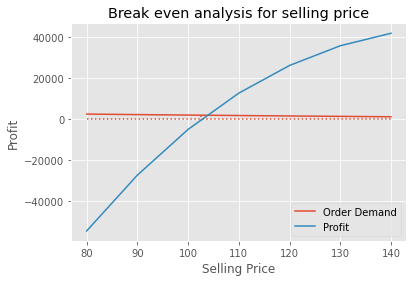

In [17]:
# Initialize plot
plt.style.use('ggplot')
fig, ax = plt.subplots()

# Create series variables
price = np.array(m1_dt1_df['selling_price'])
demand = np.array(m1_dt1_df['order_demand'])
profit = np.array(m1_dt1_df['profit'])

# Plot series
ax.plot(price, demand, label='Order Demand')
ax.plot(price, profit, label='Profit')

# Style plot elements
ax.set(title='Break even analysis for selling price', xlabel='Selling Price', ylabel='Profit')
plt.hlines(0, 80, 140, linestyles='dotted')
plt.vlines(break_even_demand, -750, 2000, linestyles='dotted')
ax.legend(loc='lower right')

# Show the plot
plt.show()

 - The graph above supports the goal seek and our previous estimate that break-even was between 100 and 110. Showing the break-even right around a selling price of 102 dollars.

### 2-way Data Table

In [18]:
# 2-way table
dt_param_ranges_2 = {'selling_price': np.arange(80, 141, 10),
                     'var_cost': np.arange(85, 111, 5)}

In [19]:
param_grid = []

keys, values = zip(*dt_param_ranges_2.items())

for scenario in product(*values):
    params = dict(zip(keys, scenario))
    param_grid.append(params)
        
print(param_grid)

[{'selling_price': 80, 'var_cost': 85}, {'selling_price': 80, 'var_cost': 90}, {'selling_price': 80, 'var_cost': 95}, {'selling_price': 80, 'var_cost': 100}, {'selling_price': 80, 'var_cost': 105}, {'selling_price': 80, 'var_cost': 110}, {'selling_price': 90, 'var_cost': 85}, {'selling_price': 90, 'var_cost': 90}, {'selling_price': 90, 'var_cost': 95}, {'selling_price': 90, 'var_cost': 100}, {'selling_price': 90, 'var_cost': 105}, {'selling_price': 90, 'var_cost': 110}, {'selling_price': 100, 'var_cost': 85}, {'selling_price': 100, 'var_cost': 90}, {'selling_price': 100, 'var_cost': 95}, {'selling_price': 100, 'var_cost': 100}, {'selling_price': 100, 'var_cost': 105}, {'selling_price': 100, 'var_cost': 110}, {'selling_price': 110, 'var_cost': 85}, {'selling_price': 110, 'var_cost': 90}, {'selling_price': 110, 'var_cost': 95}, {'selling_price': 110, 'var_cost': 100}, {'selling_price': 110, 'var_cost': 105}, {'selling_price': 110, 'var_cost': 110}, {'selling_price': 120, 'var_cost': 85},

In [20]:
# Specify desired outputs (list)
outputs = ['profit', 'order_cost']

m1_dt2_df = model_1.data_table(dt_param_ranges_2, outputs)
m1_dt2_df

,selling_price,var_cost,profit,order_cost
0,80,85,-17420.0,216140.0
1,80,90,-29840.0,228560.0
2,80,95,-42260.0,240980.0
3,80,100,-54680.0,253400.0
4,80,105,-67100.0,265820.0
5,80,110,-79520.0,278240.0
6,90,85,6180.0,195060.0
7,90,90,-5000.0,206240.0
8,90,95,-16180.0,217420.0
9,90,100,-27360.0,228600.0


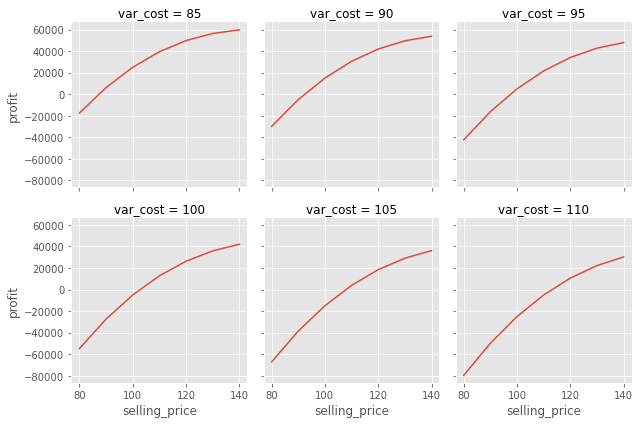

In [21]:
profit_dt_g2 = sns.FacetGrid(m1_dt2_df, col="var_cost", sharey=True, col_wrap=3)
profit_dt_g2 = profit_dt_g2.map(plt.plot, "selling_price", "profit")

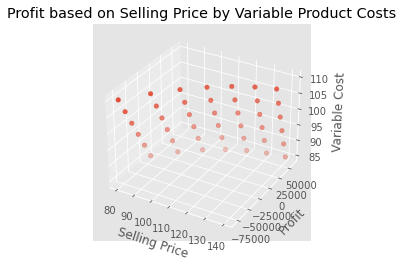

In [22]:
# Create a 3D plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(m1_dt2_df['selling_price'], m1_dt2_df['profit'], m1_dt2_df['var_cost'], 
                cmap=plt.cm.viridis)

ax.set_title('Profit based on Selling Price by Variable Product Costs')
ax.set_xlabel('Selling Price')
ax.set_ylabel('Profit')
ax.set_zlabel('Variable Cost')

plt.show();

### Digging Deeper

In [23]:
model_1.goal_seek('profit', 0, 'selling_price', 80, 250, N=100)

 - When I try to re-run the goal seek with selling price range of 80-250 I don't get a response. This is because we actually end up crossing back over the break-even point.

In [24]:
# create input parameter for price
dt_param_ranges_3 = {'selling_price': np.arange(80, 251, 10)}

# Specify desired outputs (list)
outputs = ['profit', 'order_demand']

# Use data_table function to create 1-way data table
m1_dt3_df = model_1.data_table(dt_param_ranges_3, outputs)
m1_dt3_df

,selling_price,profit,order_demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0
7,150,45000.0,1000.0
8,160,45160.0,836.0
9,170,42880.0,684.0


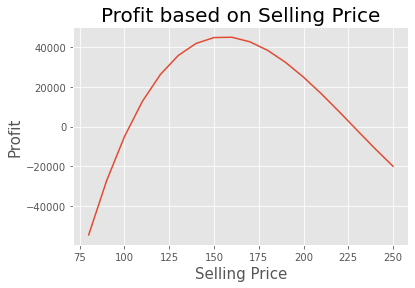

In [25]:
sns.lineplot(data = m1_dt3_df, x = "selling_price", y = "profit");

plt.title('Profit based on Selling Price', fontsize = 20)
plt.xlabel('Selling Price', fontsize = 15)
plt.ylabel('Profit', fontsize = 15);

 -  On the graph above you can clearly see that expanding the range the profit falls back below the break-even at around `selling_price` 225.

### Simulation

In [27]:
from numpy.random import default_rng
rg = default_rng(4470)

In [28]:
print(model_1)

{'fixed_cost': 5000, 'var_cost': 100, 'selling_price': 115, 'spf_constant': 4900, 'spf_linear': 35, 'spf_quadratic': 0.06}


In [29]:
m1_dt2_df.head()

,selling_price,var_cost,profit,order_cost
0,80,85,-17420.0,216140.0
1,80,90,-29840.0,228560.0
2,80,95,-42260.0,240980.0
3,80,100,-54680.0,253400.0
4,80,105,-67100.0,265820.0


In [30]:
num_reps = 100

random_inputs = {'fixed_cost': rg.uniform(4500, 5500, num_reps),
                'selling_price': rg.uniform(110, 120, num_reps)}

In [31]:
scenario_inputs = {'var_cost': np.arange(80, 120, 5)}
list(ParameterGrid(scenario_inputs))

[{'var_cost': 80},
 {'var_cost': 85},
 {'var_cost': 90},
 {'var_cost': 95},
 {'var_cost': 100},
 {'var_cost': 105},
 {'var_cost': 110},
 {'var_cost': 115}]

In [32]:
sim_outputs = ['profit']

In [33]:
model1_results = model_1.simulate(random_inputs, sim_outputs, scenario_inputs)

In [34]:
for scenario in model1_results:
    print(scenario['scenario_num'], scenario['scenario_vals'], 
          scenario['output']['profit'].mean())

0 {'var_cost': 80} 52986.670146271324
1 {'var_cost': 85} 44610.62485617499
2 {'var_cost': 90} 36234.57956607867
3 {'var_cost': 95} 27858.534275982347
4 {'var_cost': 100} 19482.488985886026
5 {'var_cost': 105} 11106.443695789701
6 {'var_cost': 110} 2730.3984056933773
7 {'var_cost': 115} -5645.646884402948


In [35]:
model1_results_df = get_sim_results_df(model1_results)

In [36]:
model1_results_df

,profit,scenario_num,var_cost
0,54794.477810,0,80
1,52562.969772,0,80
2,53139.869385,0,80
3,50543.570335,0,80
4,53373.182114,0,80
...,...,...,...
95,-2436.826021,7,115
96,-1484.972822,7,115
97,-10111.614524,7,115
98,-10385.961105,7,115


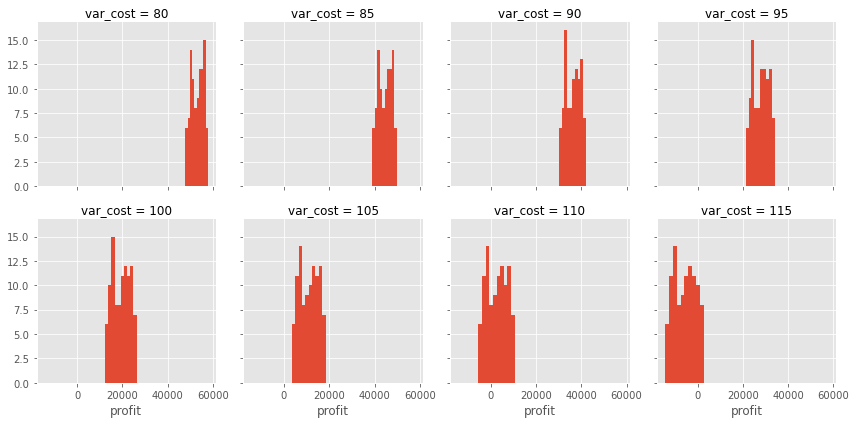

In [37]:
profit_histo_g2 = sns.FacetGrid(model1_results_df, col='var_cost', sharey=True, col_wrap=4)
profit_histo_g2 = profit_histo_g2.map(plt.hist, "profit")

In [38]:
model1_results_df.groupby(['scenario_num'])['profit'].describe()

,count,mean,std,min,25%,50%,75%,max
scenario_num,,,,,,,,
0,100.0,52986.670146,2646.475893,47852.682468,50555.573926,53110.477079,55402.455059,57713.110537
1,100.0,44610.624856,2938.011416,38977.561331,41895.216557,44703.098307,47306.900297,49854.546595
2,100.0,36234.579566,3229.926131,30102.440194,33264.453403,36326.056209,39211.345536,41995.982653
3,100.0,27858.534276,3522.125758,21227.319057,24633.690250,27949.014110,31102.753468,34137.418711
4,100.0,19482.488986,3814.544824,12352.197920,16002.927097,19571.972012,22974.033941,26278.854769
5,100.0,11106.443696,4107.136457,3477.076783,7362.869348,11194.929914,14845.314415,18420.290827
6,100.0,2730.398406,4399.866231,-5398.044354,-1275.029370,2817.887815,6716.594888,10561.726885
7,100.0,-5645.646884,4692.708295,-14273.165491,-9910.633511,-5559.154283,-1412.124639,2703.162943
